In [1]:
# Class mapping
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Setup model

In [2]:
attns = []

In [3]:
# type(attns_list)s

In [4]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# VIT.py
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x,save_flag=False, run_dir = None,img_idx = None):
        out =  self.net(x)
        if(save_flag==True):
                file_path = os.path.join(run_dir, 'ff_out.npy')
                # np.save(file_path, out)
                np.save(file_path, out[img_idx].detach().cpu().numpy())
        return out

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        

        inner_dim = dim_head *  heads  
        # print("attention : dim = ", dim, "| inner_dim = ",inner_dim,"| dim_head = ", dim_head, "| heads = ",heads  )
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)


        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x,save_flag=False, run_dir = None,img_idx = None):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)



        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        # TK NEW CODE
        global attns_list
        attns_list.append(attn)

        out = torch.matmul(attn, v)
        if(save_flag==True):

                # Convert each tensor in `qkv` to a numpy array and save it
#                 qkv=attention.to_qkv
                for i, tensor in enumerate((q,k,v)):
                    np_array = tensor[img_idx].detach().cpu().numpy()  # Convert to numpy
                    # np.save(f'qkv_{i}.npy', np_array)  # Save each as a .npy file
                    file_path = os.path.join(run_dir, f'{qkv_titles[i]}.npy')
                    np.save(file_path, np_array)
                file_path = os.path.join(run_dir, 'att_out')
                np.save(file_path, out[img_idx].detach().cpu().numpy())
                file_path = os.path.join(run_dir, 'att_score')
                np.save(file_path,attn[img_idx].detach().cpu().numpy())
        out = rearrange(out, 'b h n d -> b n (h d)')
        # return self.to_out(out),q,k,v
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        # print("transformer : dim = ", dim, "| dim_head = ", dim_head, "| heads = ",heads  )

        self.layers = nn.ModuleList([])
#         self.saved_values = {'logits': [], 'queries': [], 'keys': [], 'values': []}  # To store the values
        # self.saved_values = list()  # To store th
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x,save_flag=False, run_dir = None, img_idx = None):
        for i, (attn, ff) in enumerate(self.layers):
            # Unpack the output from the Attention layer
            #
            # print("passed trans direcetory ", run_dir, " and saving ",save_flag)
            if save_flag:
              layer_dir = os.path.join(run_dir,  f"layer {i:02}")
              os.makedirs(layer_dir, exist_ok=True)
              # print("passed trans layer direcetory ", layer_dir)
            else:
              layer_dir = None
            attn_out = attn(x,save_flag=save_flag, run_dir = layer_dir, img_idx = img_idx)



            # Save the query, key, value, and logits (output) for this layer
            # self.saved_values.append(q.cpu().detach().numpy())
            # self.saved_values.append(k.cpu().detach().numpy())
            # self.saved_values.append(v.cpu().detach().numpy())

            # Combine the attention output with the original x
            x = attn_out + x
            # self.saved_values.append(x.cpu().detach().numpy())  # Save logits
            # print("i : ",i)
            # Apply the feedforward network
#             x = ff(x) + x

            x = ff(x,save_flag=save_flag, run_dir = layer_dir, img_idx = img_idx) + x

        return x


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        # print("vit : dim = ", dim, "| dim_head = ", dim_head, "| heads = ",heads , " | mlp = ",mlp_dim )

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, save_flag=False, run_dir = None,img_idx = None):

        # if (save_flag):
          # print("\n\treached here 3")
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x,save_flag, run_dir, img_idx)
#         if(save_flag==True):
#                 # Convert each tensor in `qkv` to a numpy array and save it
#                 qkv=attention.to_qkv
#                 for i, tensor in enumerate(qkv):
#                     np_array = tensor.detach().cpu().numpy()  # Convert to numpy
#                     np.save(f'qkv_{i}.npy', np_array)  # Save each as a .npy file


        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [5]:
import argparse
import sys

# Define your arguments here
def parse_args():
    # parsers
    parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate') # resnets.. 1e-3, Vit..1e-4
    parser.add_argument('--opt', default="adam")
    parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
    parser.add_argument('--noaug', action='store_false', help='disable use randomaug')
    parser.add_argument('--noamp', action='store_true', help='disable mixed precision training. for older pytorch versions')
    parser.add_argument('--nowandb', action='store_true', help='disable wandb')
    parser.add_argument('--mixup', action='store_true', help='add mixup augumentations')
    parser.add_argument('--net', default='vit')
    parser.add_argument('--dp', action='store_true', help='use data parallel')
    parser.add_argument('--bs', default='512')
    parser.add_argument('--size', default="32")
    parser.add_argument('--n_epochs', type=int, default='200')
    parser.add_argument('--patch', default='4', type=int, help="patch for ViT")
    parser.add_argument('--dimhead', default="512", type=int)
    parser.add_argument('--convkernel', default='8', type=int, help="parameter for convmixer")

    return parser.parse_args()




In [6]:
command = 'python train_cifar10.py --n_epochs 500 --lr 0.0005'
sys.argv = command.split()[1:]
args = parse_args()

bs = int(args.bs)
imsize = int(args.size)

use_amp = not args.noamp
aug = args.noaug

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if args.net=="vit_timm":
    size = 384
else:
    size = imsize


In [7]:

def get_vit():
    return ViT(
    image_size = size,
    patch_size = args.patch,
    num_classes = 10,
    dim = int(args.dimhead),
    depth = 6,
    heads = 8,
    # mlp_dim = 512,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1,
    )

# Image loading

In [8]:
import os
import numpy as np

def load_data_from_directory(directory_path):
    """Load images, labels, outputs, and image IDs from the specified directory."""

    
    try:
        # Construct the full paths for each file
        ids_path = os.path.join(directory_path, 'ids.npy')
        images_path = os.path.join(directory_path, 'images.npy')
        labels_path = os.path.join(directory_path, 'labels.npy')
        outputs_path = os.path.join(directory_path, 'outputs.npy')

        # Load the numpy arrays
        img_ids = np.load(ids_path)
        images = np.load(images_path)
        labels = np.load(labels_path)
        outputs = np.load(outputs_path)

        return img_ids, images, labels, outputs

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None

# Example usage
directory_path = '../saved_images/correct'  # Adjust as needed
img_ids, images, labels, outputs = load_data_from_directory(directory_path)
preds = np.argmax(outputs,-1)


# Example to check the loaded data
if images is not None:
    print(f"Loaded {images.shape[0]} images, {labels.shape[0]} labels, {outputs.shape[0]} outputs, {img_ids.shape[0]} image IDs.")


Loaded 5 images, 5 labels, 5 outputs, 5 image IDs.


In [9]:
preds, labels

(array([3, 8, 0, 6, 6]), array([3, 8, 0, 6, 6]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].


Label: 6
Label class: frog
Output: 6


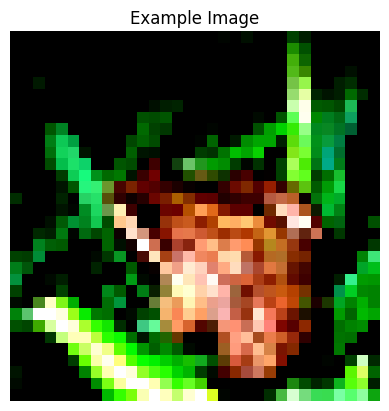

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image_idx, title=None):
    """
    Plot a single image using Matplotlib.

    Args:
        image (numpy.ndarray): The image to plot. It should be in the format (height, width, channels).
        title (str, optional): The title for the plot. Defaults to None.

    Returns:
        None
    """

    # Print label and output
    print(f"Label: {labels[image_idx]}")
    print(f"Label class: {classes[labels[image_idx]]}")
    print(f"Output: {preds[image_idx]}")

    image = images[image_idx]

    if image.ndim == 3 and image.shape[2] == 3:
        # Color image
        plt.imshow(image)
    elif image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
        # Grayscale image
        if image.ndim == 3:
            image = image.squeeze()  # Remove the channel dimension
        plt.imshow(image, cmap='gray')
    else:
        raise ValueError("Image format not recognized. Expected (H, W) or (H, W, 3) or (H, W, 1).")

    if title:
        plt.title(title)
    
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
# Assuming `images` is a numpy array of images with shape (k, H, W, C)
# and you want to plot the first image:
image_idx = 3
plot_image(image_idx, title="Example Image")


In [11]:
images.shape

(5, 32, 32, 3)

In [12]:
image_idx
images[image_idx:image_idx+1].shape


(1, 32, 32, 3)

# Getting Attention maps

In [13]:

pass

In [14]:
img_one = images[image_idx:image_idx+1]

In [15]:
img_one.shape

(1, 32, 32, 3)

In [16]:
# # tk current work:
# 1. change image to 1x3x32x32 ✅
# 2. pass one iamge and check without saving ✅
# 3. get attention maps only for one image, all layers , epoch 90 ✅
# 4. all layers, all epochs
# 5. implement code to get few images per class (GPU)
# 6. fetch images (GPU)
# 7. attention heatmaps on those

In [17]:
net = get_vit()
attns_list = []
net.eval()
with torch.inference_mode():
    out = net(torch.tensor(np.transpose(img_one, (0, 3, 1, 2))))

attns = torch.stack(attns_list)
attns = attns.squeeze(dim=1) #remove the image dimension
attns = attns.permute(1, 0, 2, 3)  # new shape is head x layer x q x k
attns.shape


torch.Size([8, 6, 65, 65])

# Visualising attention maps

In [18]:
attns.shape

torch.Size([8, 6, 65, 65])

In [19]:
layer_idx = 0
head_idx = 0
q_idx = 0

In [20]:
# tasklist : 

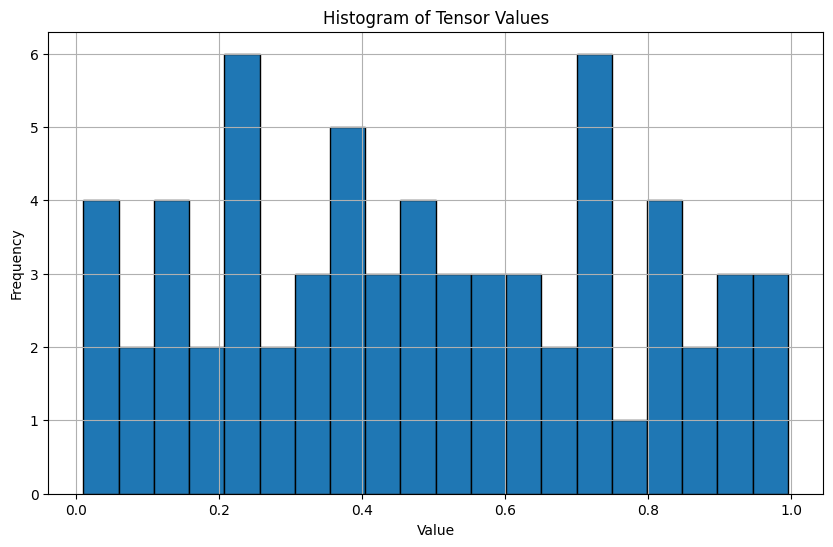

In [21]:
import torch
import matplotlib.pyplot as plt

def plot_histogram(tensor):
    # Ensure the tensor is of shape (65,)
    assert tensor.shape == (65,), "Tensor should have a shape of (65,)"
    
    # Convert tensor to numpy array for plotting
    tensor_np = tensor.cpu().numpy()
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(tensor_np, bins=20, edgecolor='black')
    plt.title("Histogram of Tensor Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example usage
tensor = torch.rand(65)  # Example tensor
plot_histogram(tensor)


In [22]:
import numpy as np

def get_std_dev_thresholds(tensor, num_bins=3):
    mean = tensor.mean().item()
    std_dev = tensor.std().item()
    thresholds = [mean - 1.5 * std_dev, mean, mean + 1.5 * std_dev]
    return thresholds

# Example usage
tensor = torch.rand(65)  # Replace with your attention scores tensor
std_dev_thresholds = get_std_dev_thresholds(tensor)
print(std_dev_thresholds)


[-0.03550665080547333, 0.3810763955116272, 0.7976594418287277]


In [23]:
# std_dev

4
59


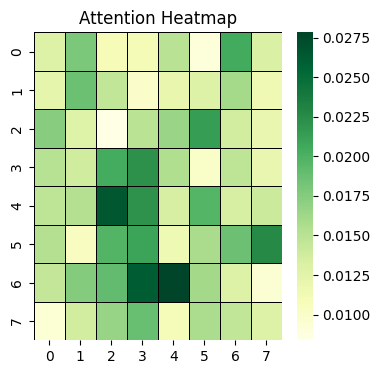

In [32]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attn_heatmap(attn_row):
    # Ensure the tensor is of shape (65,)
    assert attn_row.shape == (65,), "attn_row should have a shape of (65,)"
    
    # Remove the first element (corresponding to the [CLS] token if present)
    attn_grid = attn_row[1:]
    
    # Reshape to 8x8
    attn_grid = attn_grid.view(8, 8)
    
    # Plot the heatmap
    # plt.figure(figsize=(8, 8))
    plt.figure(figsize=(4, 4))
    sns.heatmap(attn_grid.cpu().numpy(), annot=False, cmap='YlGn', cbar=True, linewidths=0.5, linecolor='black')
    plt.title("Attention Heatmap")
    plt.show()

# Example usage
# attn_row = torch.rand(65)  # Example attention row

head_idx=np.random.randint(0,8)
print(head_idx)
#frog
q_idx=np.random.randint(0,65)
print(q_idx)
layer_idx=5
attn_row = attns[head_idx][layer_idx][q_idx]
plot_attn_heatmap(attn_row)


4
26


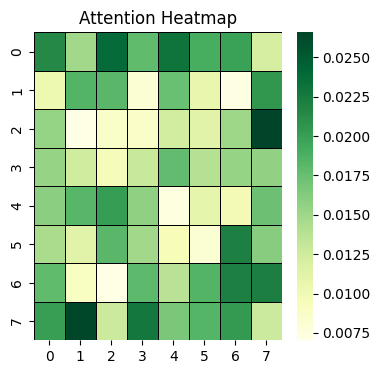

In [34]:
head_idx=np.random.randint(0,8)
print(head_idx)
## backgrounc
q_idx=np.random.randint(0,65)
print(q_idx)
layer_idx=5
attn_row = attns[head_idx][layer_idx][q_idx]
plot_attn_heatmap(attn_row)

6
60


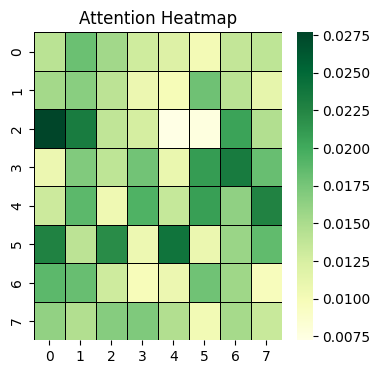

In [38]:
head_idx=np.random.randint(0,8)
print(head_idx)
# grass
q_idx=np.random.randint(0,65)
print(q_idx)
layer_idx=5
attn_row = attns[head_idx][layer_idx][q_idx]
plot_attn_heatmap(attn_row)

In [ ]:
# In future 

0
45


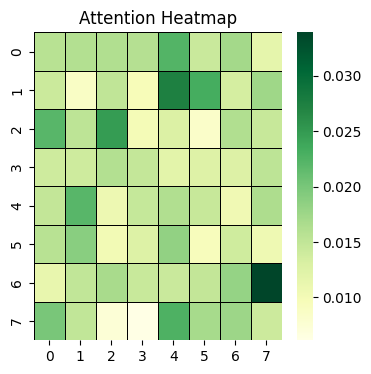

In [39]:
head_idx=np.random.randint(0,8)
print(head_idx)
# grass
q_idx=np.random.randint(0,65)
print(q_idx)
layer_idx=5
attn_row = attns[head_idx][layer_idx][q_idx]
plot_attn_heatmap(attn_row)
print(" x = ",q_idx%8," , y = ",q_idx//8)

In [42]:
print(" x = ",q_idx%8," , y = ",q_idx//8)

 x =  5  , y =  5


In [25]:
attns

tensor([[[[0.0138, 0.0144, 0.0306,  ..., 0.0164, 0.0114, 0.0104],
          [0.0192, 0.0196, 0.0171,  ..., 0.0146, 0.0217, 0.0150],
          [0.0143, 0.0182, 0.0349,  ..., 0.0186, 0.0206, 0.0201],
          ...,
          [0.0103, 0.0158, 0.0194,  ..., 0.0108, 0.0118, 0.0190],
          [0.0079, 0.0106, 0.0195,  ..., 0.0223, 0.0110, 0.0194],
          [0.0175, 0.0202, 0.0205,  ..., 0.0116, 0.0137, 0.0121]],

         [[0.0138, 0.0112, 0.0156,  ..., 0.0181, 0.0146, 0.0093],
          [0.0240, 0.0112, 0.0186,  ..., 0.0130, 0.0177, 0.0112],
          [0.0173, 0.0140, 0.0216,  ..., 0.0147, 0.0103, 0.0122],
          ...,
          [0.0215, 0.0116, 0.0139,  ..., 0.0202, 0.0201, 0.0165],
          [0.0211, 0.0110, 0.0138,  ..., 0.0127, 0.0126, 0.0165],
          [0.0081, 0.0106, 0.0166,  ..., 0.0185, 0.0121, 0.0119]],

         [[0.0087, 0.0085, 0.0110,  ..., 0.0283, 0.0164, 0.0094],
          [0.0135, 0.0198, 0.0106,  ..., 0.0197, 0.0148, 0.0190],
          [0.0101, 0.0177, 0.0162,  ..., 0

In [26]:
raise EOFError

EOFError: 

In [ ]:
write me a function that given a list of lenfth 6, and the list has inside it 6 tensors each of shape 1x8x65x65

plot me

# A

## B

In [ ]:
new code

In [ ]:
# new code 2

## C 

In [ ]:
# new cod 2

In [ ]:
def load_npy_files(base_dir, epoch, batch, layer):
    """
    Load all .npy files from a specific epoch, batch, and layer directory.

    Args:
        base_dir (str): The base directory containing all the runs.
        epoch (str): The epoch directory name (e.g., 'epoch_01').
        batch (str): The batch directory name (e.g., 'batch_0').
        layer (str): The layer directory name (e.g., 'layer_00').

    Returns:
        list: A list of numpy arrays loaded from .npy files in the specified layer directory.
    """
    # Construct the directory path
    target_dir = os.path.join(base_dir, epoch, batch, layer)
    
    # Check if the directory exists
    if not os.path.exists(target_dir):
        raise FileNotFoundError(f"Directory {target_dir} does not exist.")
    
    # List all .npy files in the directory
    npy_files = [f for f in os.listdir(target_dir) if f.endswith('.npy')]
    
    # Load each .npy file and store it in a list
    data = []
    for npy_file in npy_files:
        file_path = os.path.join(target_dir, npy_file)
        data.append(np.load(file_path))
    
    return data


## Standard Deviation of attention map


In [ ]:
def patch_standard_deviation(img_idx,epoch_no,layer,head_idx=1):

    
    epoch = 'epoch '+str(epoch_no)  # Replace with your specific epoch

    batch = 'batch 0'   # Replace with your specific batch

    layer = 'layer 0'+str(layer)  # Replace with your specific layer

    
    # npy_data = load_npy_files(base_dir, epoch, batch, layer)
    npy_data = attns[head_idx][layer_idx]


    attention=npy_data[5][img_idx]
    # attention=npy_data[5][img_idx]
    print(attention.shape)

    # Compute standard deviation across the patches
    std_devs = np.std(attention, axis=1)  # Shape: (65,)

    # print(f"Standard deviation for each query patch in head {head_idx}:")
    # print(std_devs)

    # Find the maximum standard deviation and its corresponding index
    max_std_dev = np.max(std_devs)
    max_std_dev_index = np.argmax(std_devs)
    
    # print(f"Maximum standard deviation for head {head_idx}: {max_std_dev} at query patch index {max_std_dev_index}")

    return std_devs, max_std_dev, max_std_dev_index,attention


